In [1]:
# inspired from: A deep understanding of deep learning


import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


import sys



import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# %matplotlib widget
%matplotlib notebook
%matplotlib inline


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

data = data[:,1:]

# normalize the data to a range of [-1 1] (b/c tanh output)
dataNorm = data / np.max(data)
dataNorm = 2*dataNorm - 1

dataT = torch.tensor( dataNorm ).float()

batchsize = 100

In [4]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(28*28,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,1)


  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.sigmoid( x )



dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

tensor([[0.5106],
        [0.5235],
        [0.5133],
        [0.4844],
        [0.4987],
        [0.4765],
        [0.4810],
        [0.4898],
        [0.5043],
        [0.4821]], grad_fn=<SigmoidBackward0>)

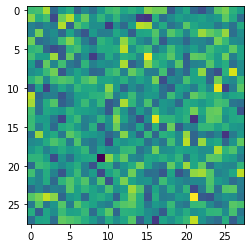

In [5]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(64,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,784)


  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.tanh( x )




gnet = generatorNet()
y = gnet(torch.randn(10,64))
plt.imshow(y[0,:].detach().squeeze().view(28,28));

In [6]:
# loss function (same for both phases of training)
lossfun = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [7]:
# this cell takes ~3 mins with 50k epochs
num_epochs = 50000

losses  = np.zeros((num_epochs,2))
disDecs = np.zeros((num_epochs,2)) # disDecs = discriminator decisions

for epochi in range(num_epochs):
    
  randidx     = torch.randint(dataT.shape[0],(batchsize,))
  real_images = dataT[randidx,:].to(device)
  fake_images = gnet( torch.randn(batchsize,64).to(device) ) # output of generator


  real_labels = torch.ones(batchsize,1).to(device)
  fake_labels = torch.zeros(batchsize,1).to(device)



  ### ---------------- Train the discriminator ---------------- ###

  pred_real   = dnet(real_images)              # REAL images into discriminator
  d_loss_real = lossfun(pred_real,real_labels) # all labels are 1
  
  pred_fake   = dnet(fake_images)              # FAKE images into discriminator
  d_loss_fake = lossfun(pred_fake,fake_labels) # all labels are 0
  
  # collect loss (using combined losses)
  d_loss = d_loss_real + d_loss_fake
  losses[epochi,0]  = d_loss.item()
  disDecs[epochi,0] = torch.mean((pred_real>.5).float()).detach()

  # backprop
  d_optimizer.zero_grad()
  d_loss.backward()
  d_optimizer.step()

  
  

  ### ---------------- Train the generator ---------------- ###

  fake_images = gnet( torch.randn(batchsize,64).to(device) )
  pred_fake   = dnet(fake_images)
  
  g_loss = lossfun(pred_fake,real_labels)
  losses[epochi,1]  = g_loss.item()
  disDecs[epochi,1] = torch.mean((pred_fake.cpu()>.5).float()).detach()
  
  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()

  
  if (epochi+1)%500==0:
    msg = f'Finished epoch {epochi+1}/{num_epochs}'
    sys.stdout.write('\r' + msg)
  

Finished epoch 50000/50000

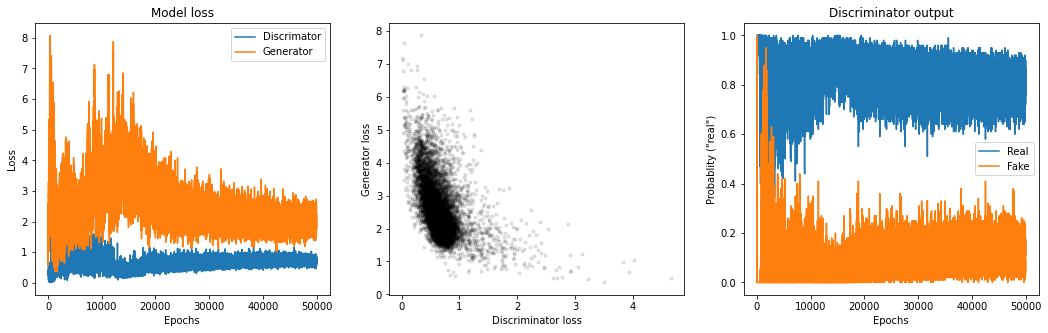

In [8]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

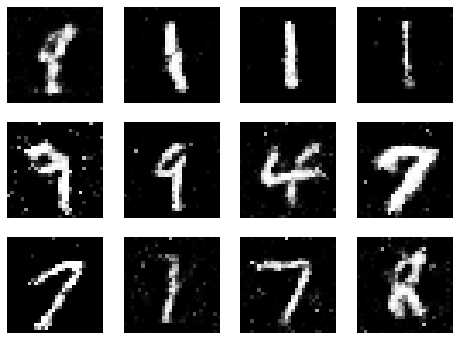

In [9]:
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()

fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.show()